-----
# <b> Altegrad 2023/2024 - LAB 7
# <b> Learning on Sets and Graph Generative Models
# <b> Matteo Marengo - matteo.marengo@ens-paris-saclay.fr
# <b> Part 1 - DeepSets
-----

## <b> TASK 1 / 2

In [5]:
"""
Learning on Sets and Graph Generative Models - ALTEGRAD - Nov 2023
Matteo Marengo - matteo.marengo@ens-paris-saclay.fr
utils.py - 1/4
"""

import numpy as np


def create_train_dataset():
    n_train = 100000
    max_train_card = 10

    ############## Task 1
    
    # Initialize the training data arrays
    X_train = np.zeros((n_train, max_train_card))
    y_train = np.zeros(n_train)

    for i in range(n_train):
        card = np.random.randint(1, max_train_card + 1)
        X_train[i, -card:] = np.random.randint(1, max_train_card + 1, size=card)  # Digits between 1 and 10
        y_train[i] = np.sum(X_train[i,:])

    print("The 1st training sample is ", X_train[0,:])
    print("The first label is ", y_train[0])

    return X_train, y_train


def create_test_dataset():
    
    ############## Task 2
    n_test = 200000
    min_test_card = 5
    max_test_card = 101
    step_test_card = 5
    cards = range(min_test_card, max_test_card, step_test_card)
    n_samples_per_card = 1000

    X_test = list()
    y_test = list()

    for card in cards:
        X = np.random.randint(1, 11, size=(n_samples_per_card, card))
        y = np.sum(X, axis=1)

        X_test.append(X)
        y_test.append(y)
    
    return X_test, y_test

## <b> TASK 3 / 4

In [6]:
"""
Learning on Sets and Graph Generative Models - ALTEGRAD - Nov 2023
Matteo Marengo - matteo.marengo@ens-paris-saclay.fr
models.py - 2/4
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepSets(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim):
        super(DeepSets, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        
        ############## Task 3
    
        x = self.embedding(x)  # Apply embedding
        x = self.tanh(self.fc1(x))  # Apply first fully connected layer and tanh activation
        x = torch.sum(x, dim=1)  # Sum aggregator
        x = self.fc2(x)  # Apply output layer
        return x.squeeze()


class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        
        ############## Task 4
    
        x = self.embedding(x)  # Apply embedding
        # LSTM layer
        # We only use the hidden state of the last time step
        _, (h_n, _) = self.lstm(x)  # h_n is the hidden state for the last time step
        # Fully connected layer
        x = self.fc(h_n)
        
        return x.squeeze()

## <b> TASK 5

In [7]:
"""
Learning on Sets and Graph Generative Models - ALTEGRAD - Nov 2023
Matteo Marengo - matteo.marengo@ens-paris-saclay.fr
train.py - 3/4
"""

import time
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn

# from utils import create_train_dataset
# from models import DeepSets, LSTM


# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 20
batch_size = 64
embedding_dim = 128
hidden_dim = 64
learning_rate = 0.001

# Generates training data
X_train, y_train = create_train_dataset()
n_train = 100000
n_digits = 11

# Initializes DeepSets model and optimizer
deepsets = DeepSets(n_digits, embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(deepsets.parameters(), lr=learning_rate)
loss_function = nn.L1Loss()

# Trains the DeepSets model
for epoch in range(epochs):
    t = time.time()
    deepsets.train()
     
    train_loss = 0
    count = 0
    idx = np.random.permutation(n_train)
    for i in range(0, n_train, batch_size):
        
        ############## Task 5

        # Prepare batch
        indices = idx[i:min(i + batch_size, n_train)] 
        x_batch = X_train[indices,:]
        y_batch = y_train[indices]

        # Convert to PyTorch tensors
        x_batch = torch.from_numpy(x_batch).long()  # Assuming X_train is in numpy array format
        y_batch = torch.from_numpy(y_batch).float()  # Assuming y_train is in numpy array format

        optimizer.zero_grad()
        output = deepsets(x_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * output.size(0)
        count += output.size(0)
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(train_loss / count),
          'time: {:.4f}s'.format(time.time() - t))

# Stores DeepSets model into disk
torch.save({
    'state_dict': deepsets.state_dict(),
    'optimizer' : optimizer.state_dict(),
}, 'model_deepsets.pth.tar')

print("Finished training for DeepSets model")
print()

# Initializes LSTM model and optimizer
lstm = LSTM(n_digits, embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)
loss_function = nn.L1Loss()

# Trains the LSTM model
for epoch in range(epochs):
    t = time.time()
    lstm.train()
     
    train_loss = 0
    count = 0
    idx = np.random.permutation(n_train)
    for i in range(0, n_train, batch_size):
    
        ############## Task 5
        
        # Prepare batch
        indices = idx[i:i + batch_size]
        x_batch = X_train[indices]
        y_batch = y_train[indices]

        # Convert to PyTorch tensors
        x_batch = torch.from_numpy(x_batch).long()  # Assuming X_train is in numpy array format
        y_batch = torch.from_numpy(y_batch).float()  # Assuming y_train is in numpy array format
        
        optimizer.zero_grad()
        output = lstm(x_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * output.size(0)
        count += output.size(0)
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(train_loss / count),
          'time: {:.4f}s'.format(time.time() - t))

# Stores LSTM model into disk
torch.save({
    'state_dict': lstm.state_dict(),
    'optimizer' : optimizer.state_dict(),
}, 'model_lstm.pth.tar')

print("Finished training for LSTM model")

The 1st training sample is  [0. 0. 0. 0. 0. 0. 0. 3. 3. 6.]
The first label is  12.0
Epoch: 0001 loss_train: 0.9442 time: 6.5313s
Epoch: 0002 loss_train: 0.0683 time: 4.8033s
Epoch: 0003 loss_train: 0.0541 time: 6.8483s
Epoch: 0004 loss_train: 0.0465 time: 5.3341s
Epoch: 0005 loss_train: 0.0403 time: 5.3342s
Epoch: 0006 loss_train: 0.0358 time: 6.3611s
Epoch: 0007 loss_train: 0.0339 time: 4.8357s
Epoch: 0008 loss_train: 0.0317 time: 4.9580s
Epoch: 0009 loss_train: 0.0314 time: 5.9576s
Epoch: 0010 loss_train: 0.0299 time: 5.7669s
Epoch: 0011 loss_train: 0.0294 time: 7.3802s
Epoch: 0012 loss_train: 0.0278 time: 5.5438s
Epoch: 0013 loss_train: 0.0300 time: 5.9883s
Epoch: 0014 loss_train: 0.0270 time: 5.5585s
Epoch: 0015 loss_train: 0.0257 time: 6.3524s
Epoch: 0016 loss_train: 0.0264 time: 5.6135s
Epoch: 0017 loss_train: 0.0268 time: 6.4382s
Epoch: 0018 loss_train: 0.0266 time: 6.4208s
Epoch: 0019 loss_train: 0.0254 time: 5.9293s
Epoch: 0020 loss_train: 0.0255 time: 5.5825s
Finished traini

# <b> TASK 6 / 7

Loading DeepSets checkpoint!
Loading LSTM checkpoint!


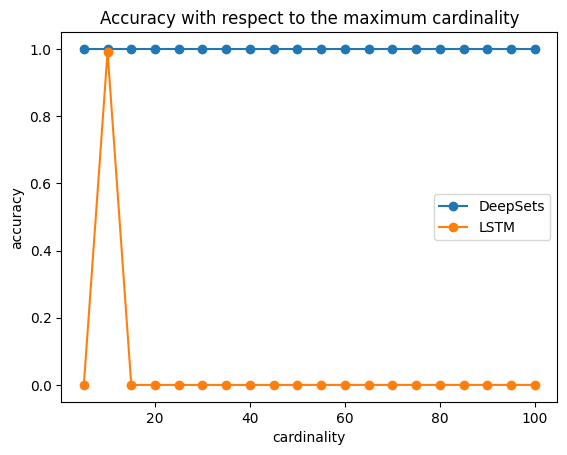

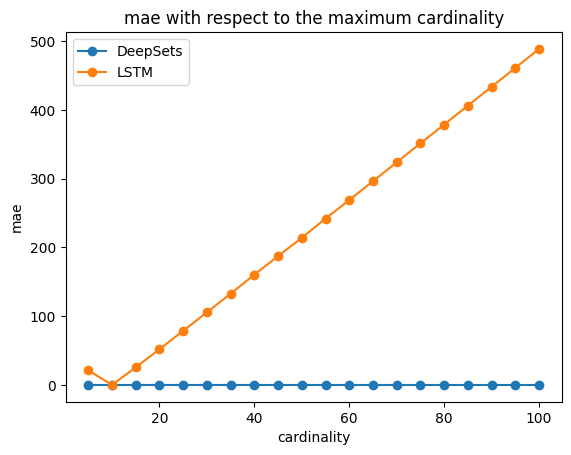

In [8]:
"""
Learning on Sets and Graph Generative Models - ALTEGRAD - Nov 2023
Matteo Marengo - matteo.marengo@ens-paris-saclay.fr
eval.py - 4/4
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_absolute_error
import torch
import time
# from utils import create_test_dataset
# from models import DeepSets, LSTM

# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
batch_size = 64
embedding_dim = 128
hidden_dim = 64

# Generates test data
X_test, y_test = create_test_dataset()
cards = [X_test[i].shape[1] for i in range(len(X_test))]
n_samples_per_card = X_test[0].shape[0]
n_digits = 11

# Retrieves DeepSets model
deepsets = DeepSets(n_digits, embedding_dim, hidden_dim).to(device)
print("Loading DeepSets checkpoint!")
checkpoint = torch.load('model_deepsets.pth.tar')
deepsets.load_state_dict(checkpoint['state_dict'])
deepsets.eval()

# Retrieves LSTM model
lstm = LSTM(n_digits, embedding_dim, hidden_dim).to(device)
print("Loading LSTM checkpoint!")
checkpoint = torch.load('model_lstm.pth.tar')
lstm.load_state_dict(checkpoint['state_dict'])
lstm.eval()

# Dict to store the results
results = {'deepsets': {'acc':[], 'mae':[]}, 'lstm': {'acc':[], 'mae':[]}}

for i in range(len(cards)):
    y_pred_deepsets = list()
    y_pred_lstm = list()
    for j in range(0, n_samples_per_card, batch_size):
        
        ############## Task 6
    
        ##################
        # your code here #
        x_batch = X_test[i][j:min(j+batch_size, n_samples_per_card), :]
        x_batch = torch.LongTensor(x_batch).to(device)
        
        outpout_deepset = deepsets(x_batch)
        y_pred_deepsets.append(outpout_deepset)
        
        output_lsstm = lstm(x_batch)
        y_pred_lstm.append(output_lsstm)
        ##################
        
    y_pred_deepsets = torch.cat(y_pred_deepsets)
    y_pred_deepsets = y_pred_deepsets.detach().cpu().numpy()
    
    acc_deepsets = accuracy_score(y_test[i], np.round(y_pred_deepsets))
    mae_deepsets = mean_absolute_error(y_test[i], np.round(y_pred_deepsets))
    results['deepsets']['acc'].append(acc_deepsets)
    results['deepsets']['mae'].append(mae_deepsets)
    
    y_pred_lstm = torch.cat(y_pred_lstm)
    y_pred_lstm = y_pred_lstm.detach().cpu().numpy()
    
    acc_lstm = accuracy_score(y_test[i], np.round(y_pred_lstm))
    mae_lstm = mean_absolute_error(y_test[i], np.round(y_pred_lstm))
    results['lstm']['acc'].append(acc_lstm)
    results['lstm']['mae'].append(mae_lstm)


############## Task 7
    
plt.plot(cards, results['deepsets']['acc'], '-o', label='DeepSets')
plt.plot(cards, results['lstm']['acc'], '-o', label='LSTM')
plt.xlabel('cardinality')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy with respect to the maximum cardinality')
plt.show()

plt.plot(cards, results['deepsets']['mae'], '-o', label='DeepSets')
plt.plot(cards, results['lstm']['mae'], '-o', label='LSTM')
plt.xlabel('cardinality')
plt.ylabel('mae')
plt.legend()
plt.title('mae with respect to the maximum cardinality')
plt.show()